In [1]:
import numpy as np
import rebound as rb
import matplotlib.pyplot as plt
# We'll import some convenience functions for working with
# REBOUND simulations
from celmech.nbody_simulation_utilities import align_simulation, set_timestep
from celmech.nbody_simulation_utilities import get_simarchive_integration_results

# Define a function to initialize a rebound simulation. 
def get_sim(scale = 0.05):
        sim = rb.Simulation()
        sim.add(m=1)
        for i in range(1,4):
            sim.add(m=i * 1e-5 , a = 2**i,
                    e = np.random.rayleigh(scale),
                    inc = np.random.rayleigh(scale),
                    l = 'uniform',
                    pomega = 'uniform',
                    Omega = 'uniform'
                   )
        sim.move_to_com()
        align_simulation(sim)

        sim.integrator = 'whfast'
        sim.ri_whfast.safe_mode=0
        set_timestep(sim,1/40) # set timestep to 1/40th of shortest orbital period
        return sim


In [2]:
from celmech.secular import LaplaceLagrangeSystem
sim = get_sim()
llsystem = LaplaceLagrangeSystem.from_Simulation(sim)

In [3]:
Tsec = llsystem.Tsec # Shortest secular mode period of the system
sim.automateSimulationArchive("secular_example.sa",interval=Tsec/100,deletefile=True)
sim.integrate(10 * Tsec)
sa = rb.SimulationArchive("secular_example.sa")
nbody_results = get_simarchive_integration_results(sa)


In [4]:
llsoln = llsystem.secular_solution(nbody_results['time'])

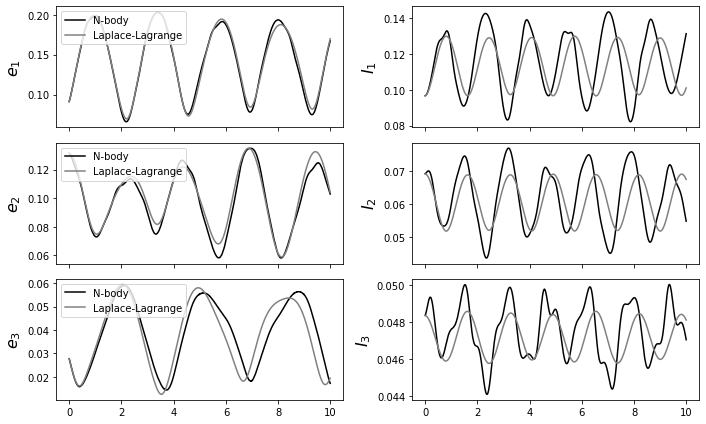

In [6]:
fig,ax = plt.subplots(sim.N-1,2,sharex=True,figsize=(10,6))
for i in range(sim.N-1):

    ax[i,0].plot(nbody_results['time'] / Tsec, nbody_results['e'][i],'k',label="N-body")
    ax[i,0].set_ylabel("$e_{}$".format(i+1),fontsize=16)
    ax[i,1].plot(nbody_results['time'] / Tsec, nbody_results['inc'][i],'k')
    ax[i,1].set_ylabel("$I_{}$".format(i+1),fontsize=16)

    ax[i,0].plot(llsoln['time']/ Tsec, llsoln['e'][i],'gray',label="Laplace-Lagrange")
    ax[i,1].plot(llsoln['time']/ Tsec, llsoln['inc'][i],'gray')

    ax[i,0].legend(loc='upper left')
plt.tight_layout()
plt.savefig("/Users/shadden/Projects/celmech/docs/images/secular_nbody_ll_compare.png")

In [7]:
from celmech.secular import SecularSystemSimulation

In [8]:
sim0=sa[0]
sec_sim = SecularSystemSimulation.from_Simulation(
    sim0,
    max_order = 4,
    dtFraction=1/100.,
    DFOp_kwargs={'rtol':1e-10}
)

In [9]:
def run_secular_sim(sec_sim,times, corrector=True):
    N = len(times)
    eccN,incN,pomegaN,OmegaN = np.zeros((4,sec_sim.state.N - 1,N))
    Eerr = np.zeros(N)
    AMDerr = np.zeros(N)
    timesDone = np.zeros(N)
    E0 = sec_sim.calculate_energy()
    AMD0 = sec_sim.calculate_AMD()
    for i,time in enumerate(times):
        sec_sim.integrate(time, corrector=corrector)
        timesDone[i] = sec_sim.t
        E = sec_sim.calculate_energy()
        AMD = sec_sim.calculate_AMD()
        Eerr[i] = np.abs((E-E0)/E0)
        AMDerr[i] = np.abs((AMD-AMD0)/AMD0)
        for j,p in enumerate(sec_sim.state.particles[1:]):
            eccN[j,i] = p.e
            incN[j,i] = p.inc
            pomegaN[j,i] = p.pomega
            OmegaN[j,i] = p.Omega
    return timesDone, Eerr, AMDerr, eccN, incN,pomegaN,OmegaN

In [11]:
T = np.linspace(0,sa[-1].t,150)
times_sec, Eerr, AMDerr, ecc_sec, inc_sec,pomega_sec,Omega_sec = run_secular_sim(sec_sim,T)

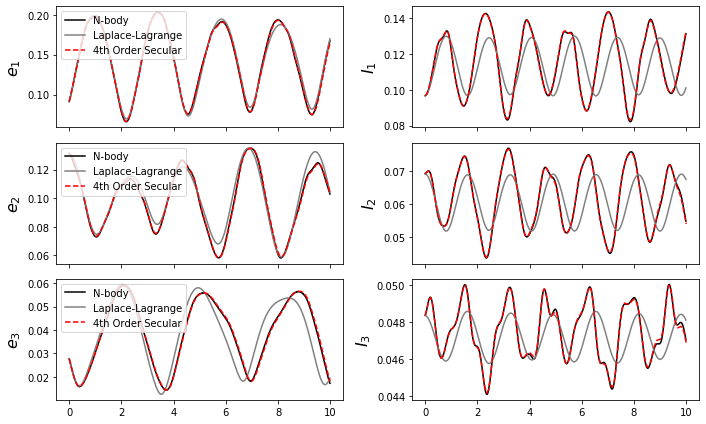

In [13]:
fig,ax = plt.subplots(sim.N-1,2,sharex=True,figsize=(10,6))
for i in range(sim.N-1):
    # N-body
    ax[i,0].plot(nbody_results['time'] / Tsec, nbody_results['e'][i],'k',label="N-body")
    ax[i,0].set_ylabel("$e_{}$".format(i+1),fontsize=16)
    ax[i,1].plot(nbody_results['time'] / Tsec, nbody_results['inc'][i],'k')
    ax[i,1].set_ylabel("$I_{}$".format(i+1),fontsize=16)

    # Laplace-Lagrange
    ax[i,0].plot(llsoln['time']/ Tsec, llsoln['e'][i],'gray',label="Laplace-Lagrange")
    ax[i,1].plot(llsoln['time']/ Tsec, llsoln['inc'][i],'gray')

    # Secular Simulation
    ax[i,0].plot(times_sec/ Tsec, ecc_sec[i],'r--',label="4th Order Secular")
    ax[i,1].plot(times_sec/ Tsec, inc_sec[i],'r--')


    ax[i,0].legend(loc='upper left')a
plt.tight_layout()
plt.savefig("/Users/shadden/Projects/celmech/docs/images/secular_nbody_ll_4thOrder_compare.png")